In [2]:
import matplotlib.pyplot as plt
from helpers.cm26 import DatasetCM26, operator_coarsen, operator_coarsen_weighted, operator_Kochkov, operator_gaussian
from helpers.computational_tools import select_NA, select_LatLon, select_Pacific, select_Cem, StateFunctions, compare, select_Equator
from helpers.ann_tools import ANN, import_ANN, minibatch, export_ANN
import numpy as np
import xarray as xr
import cftime
%load_ext autoreload
%autoreload 3

In [3]:
ds = DatasetCM26()

In [4]:
ann_Txy = import_ANN('trained_models/ANN_CM26/Txy_epoch_2000.nc')
ann_Txx_Tyy = import_ANN('trained_models/ANN_CM26/Txx_Tyy_epoch_2000.nc')

# Kochkov coarsegraining

In [5]:
time = 7000
Kochkov = ds.sample_epoch(time=time, factors=[4], percentile=1, operator=operator_Kochkov)[4]
control = ds.sample_epoch(time=time, factors=[4], percentile=1, operator=operator_coarsen)[4]

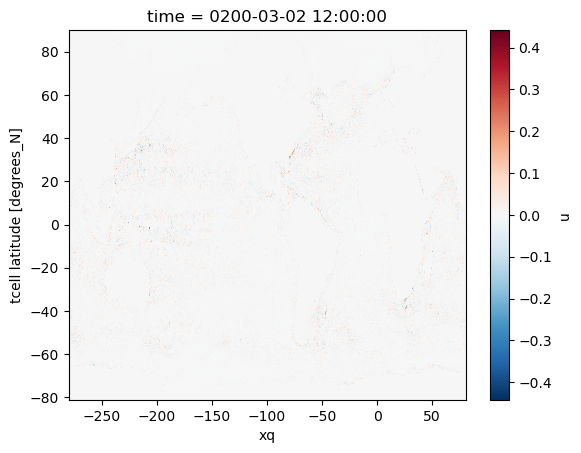

In [6]:
(Kochkov.data.u-control.data.u).plot()

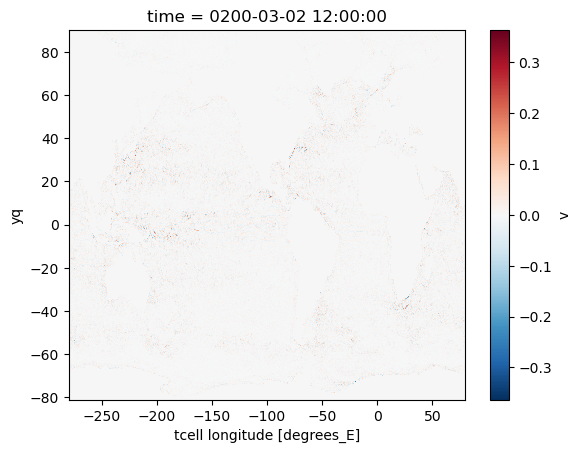

In [7]:
(Kochkov.data.v-control.data.v).plot()

# Testing boundary mask as in Cem paper

In [37]:
%time dataset = ds.sample_epoch(time=np.random.randint(6950,8035), factors=[4], percentile=1, operator=operator_Kochkov)[4]

CPU times: user 4.56 s, sys: 1.38 s, total: 5.94 s
Wall time: 5.57 s


Correlation: 0.5133800826939009
Relative Error: 1.0020579671275986
R2 =  0.26278361321105326
R2 max =  0.26390173528928085
Optinal scaling: 0.9388865757876972
Nans [test/control]: [1935, 1935]


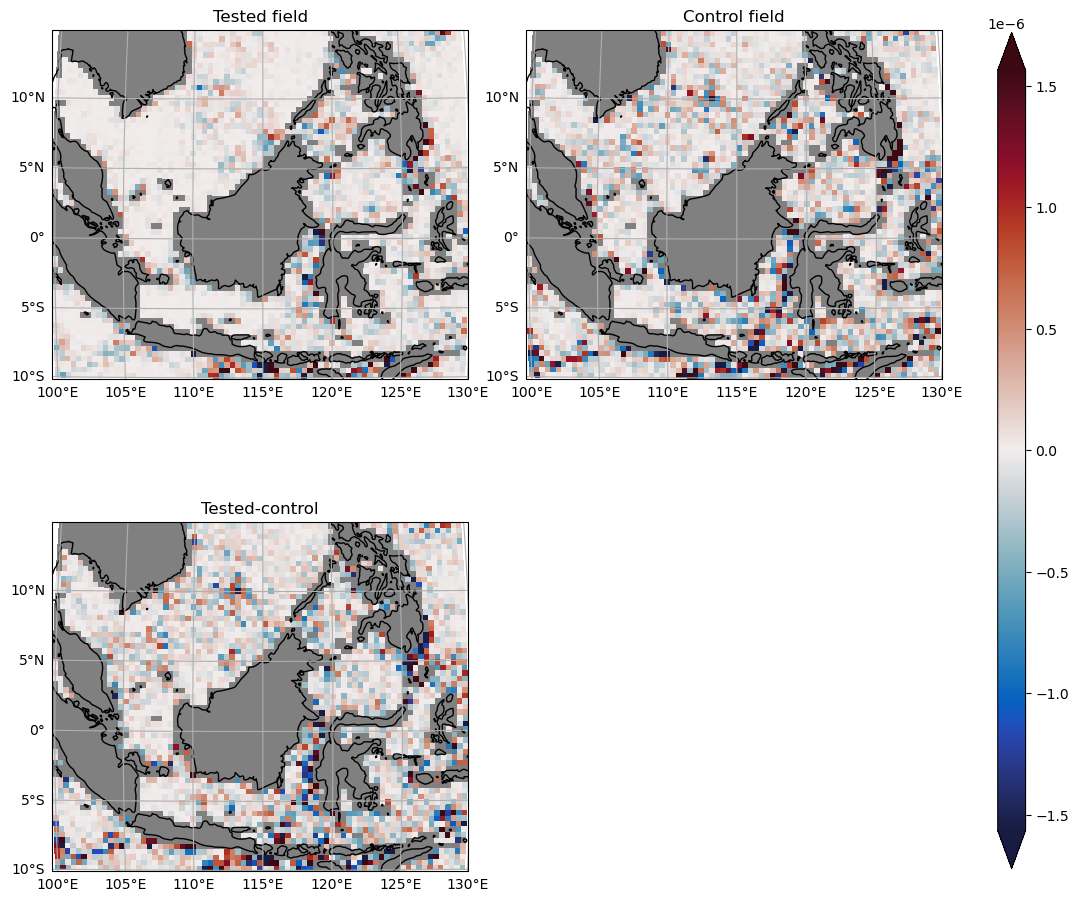

In [38]:
ann = dataset.state.ANN(ann_Txy=ann_Txy, ann_Txx_Tyy=ann_Txx_Tyy)
compare(ann['ZB20u'], dataset.data.SGSx, mask=dataset.param.wet_u, selector=select_Cem)

# Testing energy and enstrophy exchange

In [56]:
time = np.random.randint(6950,8035)
for factor in [4, 10, 20]:
    print(f'############# factor {factor} ##############')
    for operator in ['operator_coarsen', 'operator_coarsen_weighted', 'operator_gaussian', 'operator_Kochkov']:
        print('------------ ',operator,' --------------')
        for percentile in [0, 1, 0.5]:
            dataset = ds.sample_epoch(time=time, 
                factors=[factor], percentile=percentile, operator=eval(operator))[factor]
            source = dataset.state.compute_EZ_source(dataset.data.SGSx, dataset.data.SGSy)
            print(f'perc.={percentile}, dEdt={source["dEdt"]}, dZdt={source["dZdt"]}, dPdt={source["dPdt"]}')
        print('\n')

############# factor 4 ##############
------------  operator_coarsen  --------------
perc.=0, dEdt=465871.59293358383, dZdt=-0.00039597991505935167, dPdt=-2.686345486387209e-12
perc.=1, dEdt=440815.3266702702, dZdt=-0.0003229406295153671, dPdt=-2.8854456391155176e-12
perc.=0.5, dEdt=473410.4203158737, dZdt=-0.00032712644580659077, dPdt=-2.242292107284825e-12


------------  operator_coarsen_weighted  --------------
perc.=0, dEdt=463851.8826811256, dZdt=-0.00039586983464514903, dPdt=-2.6827814464613476e-12
perc.=1, dEdt=438940.12686981703, dZdt=-0.00032298723261912747, dPdt=-2.883226831373951e-12
perc.=0.5, dEdt=471458.75347379263, dZdt=-0.0003271889888652023, dPdt=-2.2405002821383184e-12


------------  operator_gaussian  --------------
perc.=0, dEdt=591945.040788818, dZdt=-0.00020834398742656423, dPdt=-1.4960552190143967e-12
perc.=1, dEdt=593084.6713045086, dZdt=-0.00013748030157441073, dPdt=-1.4764679323567651e-12
perc.=0.5, dEdt=597443.7387263768, dZdt=-0.000153336591547133, dPdt=-1

In [2]:
import xarray as xr
import numpy as np
x=xr.DataArray(np.arange(10))

In [17]:
x.rolling({'dim_0':4}).mean()

<xarray.DataArray (dim_0: 10)>
array([nan, nan, nan, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5])
Dimensions without coordinates: dim_0

In [12]:
x[0:4].mean()

<xarray.DataArray ()>
array(1.5)

In [13]:
x[4:8].mean()

<xarray.DataArray ()>
array(5.5)